<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu113 True
1.2.2


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [2]:
import os
if "mmsegmentation" not in os.getcwd():
    os.chdir("mmsegmentation")

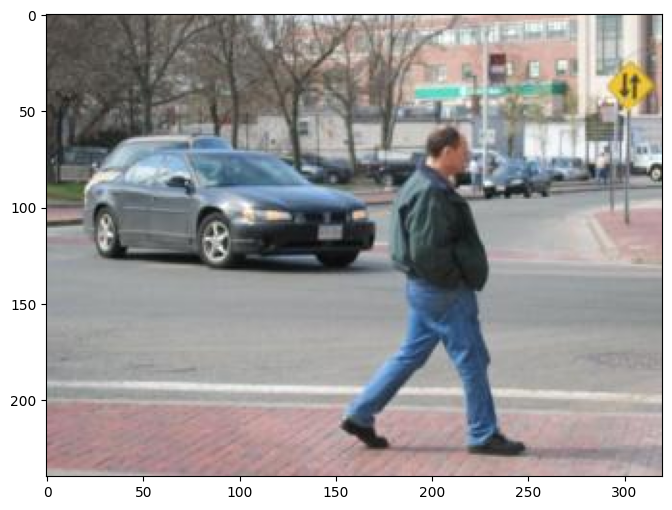

In [3]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [4]:
dd = {0: 'shirt, blouse', 1: 'top, t-shirt, sweatshirt', 2: 'sweater', 3: 'cardigan', 4: 'jacket', 5: 'vest', 6: 'pants', 7: 'shorts', 
          8: 'skirt', 9: 'coat', 10: 'dress', 11: 'jumpsuit', 12: 'cape', 13: 'glasses', 14: 'hat', 15: 'headband, head covering, hair accessory', 
          16: 'tie', 17: 'glove', 18: 'watch', 19: 'belt', 20: 'leg warmer', 21: 'tights, stockings', 22: 'sock', 23: 'shoe', 24: 'bag, wallet', 
          25: 'scarf', 26: 'umbrella', 27: 'hood', 28: 'collar', 29: 'lapel', 30: 'epaulette', 31: 'sleeve', 32: 'pocket', 33: 'neckline', 
          34: 'buckle', 35: 'zipper', 36: 'applique', 37: 'bead', 38: 'bow', 39: 'flower', 40: 'fringe', 41: 'ribbon', 42: 'rivet', 43: 'ruffle', 
          44: 'sequin', 45: 'tassel'}
print(list(dd.values()))

COLORS = [
    (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184),
    (20, 165, 16), (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122),
    (43, 152, 125), (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116),
    (216, 21, 138), (100, 0, 176), (171, 236, 47), (193, 137, 224), (36, 152, 214), (154, 165, 67), (73, 8, 110),
    (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184), (20, 165, 16),
    (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122), (43, 152, 125),
    (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198)
]

print(len(COLORS))

['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
46


In [84]:
# define dataset root and directory for images and annotations
data_root = 'fashion'
img_dir = 'images'
ann_dir = 'annotations'
# define class and palette for better visualization
classes = ('background', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 
            'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 
            'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 
            'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel')
palette = [(0,0,0),
            (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184),
            (20, 165, 16), (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122),
            (43, 152, 125), (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116),
            (216, 21, 138), (100, 0, 176), (171, 236, 47), (193, 137, 224), (36, 152, 214), (154, 165, 67), (73, 8, 110),
            (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184), (20, 165, 16),
            (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122), (43, 152, 125),
            (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198)
        ]
print(len(palette))
print(len(classes))

47
47


In [6]:
import os.path as osp
import numpy as np
from PIL import Image

# # convert dataset annotation to semantic segmentation map
# for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                          '.png')))

In [85]:
img_ = plt.imread('fashion/annotations/train2020/0a0a539316af6547b3bbe228ead13730_seg.png')
np.histogram(img_)

(array([606610,      0,  75870,      0,      0,      0,   9856,      0,
           639,   5393]),
 array([0.        , 0.01568628, 0.03137255, 0.04705882, 0.0627451 ,
        0.07843138, 0.09411765, 0.10980392, 0.1254902 , 0.14117648,
        0.15686275], dtype=float32))

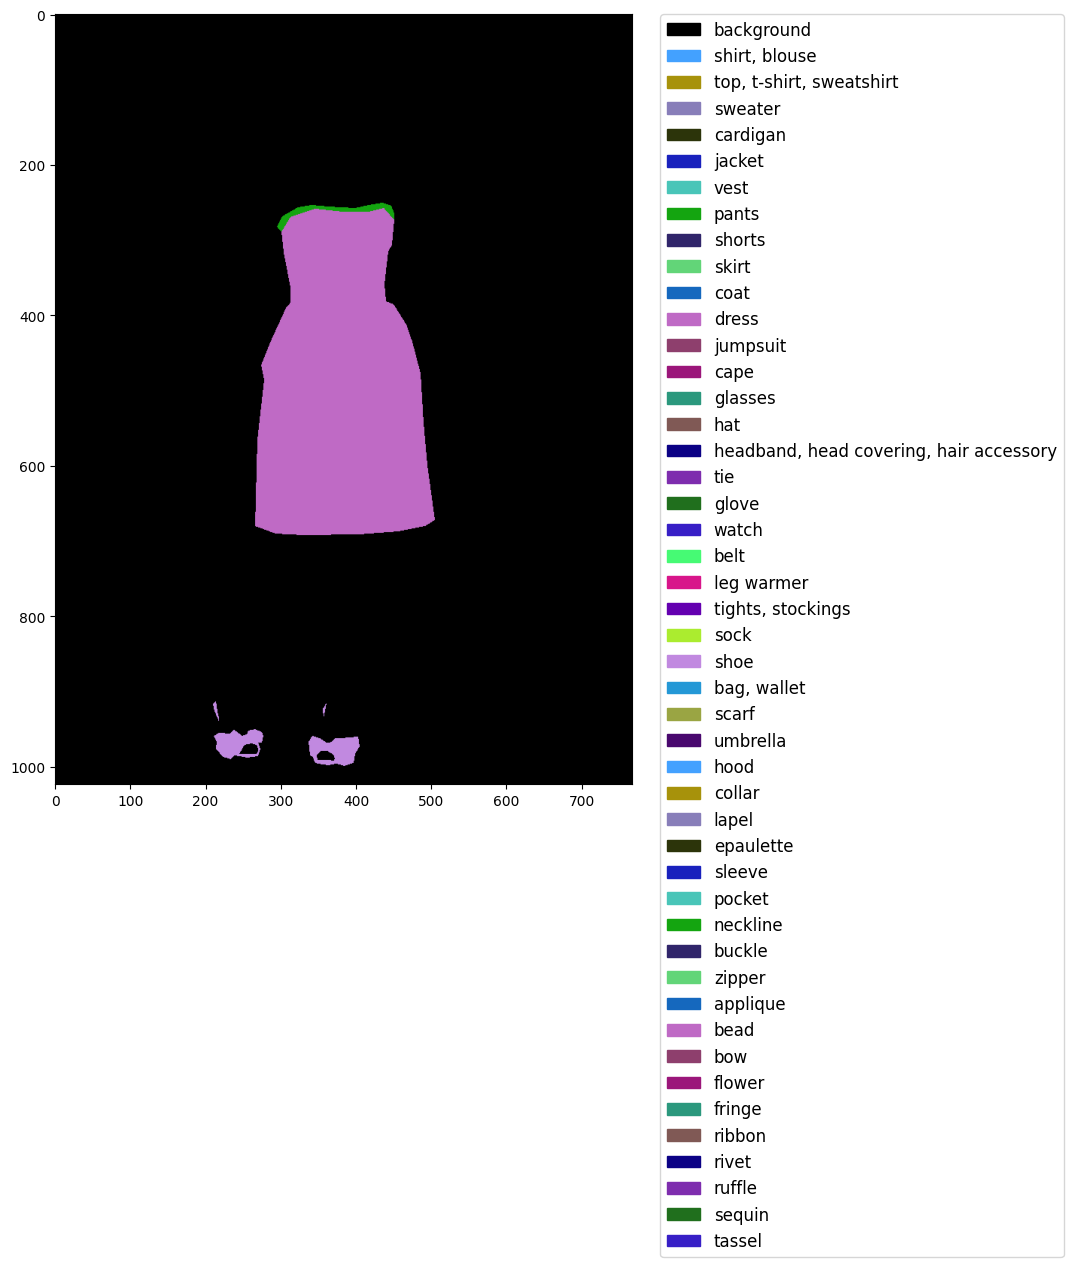

In [86]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15, 10))
# im = plt.imshow(np.array(img.convert('RGB')))

mask = cv2.imread('fashion/annotations/train2020/0a0f64ffdb6aa45b0f445b217b05a6c6_seg.png', cv2.IMREAD_GRAYSCALE)

# For all the values in the mask, we will create a new mask with the same shape but with the color of the category
mask_color = np.zeros((mask.shape[0], mask.shape[1], 3))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = palette[mask[i, j]]

mask_color = mask_color.astype(np.uint8)
plt.imshow(mask_color)
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [22]:
# ls_test = [fn for fn in os.listdir('fashion/images/val2020') if fn.split('.')[0]+'_seg.png' not in os.listdir('fashion/annotations/val2020')]
# import shutil

# # Move a file from source to destination
# [shutil.move('fashion/images/val2020/'+fn_test, 'fashion/images/test2020/'+fn_test) for fn_test in ls_test if fn_test not in os.listdir('fashion/images/test2020')]

In [9]:
# # split train/val set randomly
# split_dir = 'splits'
# mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_train = [filename.split('_')[0] for filename in mmengine.scandir(osp.join(data_root, ann_dir, 'train2020'), suffix='_seg.png')]
# filename_val = [filename.split('_')[0] for filename in mmengine.scandir(osp.join(data_root, ann_dir, 'val2020'), suffix='_seg.png')]

# print(len(filename_train))
# print(filename_train[:5])
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = len(filename_train)
#   f.writelines(line + '\n' for line in filename_train)
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as train set
#   f.writelines(line + '\n' for line in filename_val)



45623
['6cebbd44c53ce202644553bba49412eb', 'dcb76ab3d0c58169e45581cc9a7674b7', '8edd63f2baf7583a85889dde6ad9e3ca', '3e9ccab9cb38b5ea81a4ae05b31eda79', '671d0ac01055d443d07bcc276d59cd16']


After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [88]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class FashionBG(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='_seg.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [90]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation


In [91]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [93]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 47
cfg.model.auxiliary_head.num_classes = 47

# Modify dataset type and path
cfg.dataset_type = 'FashionBG'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path='images/train2020', seg_map_path='annotations/train2020')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
# cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path='images/val2020', seg_map_path='annotations/val2020')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
# cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'fashion'
dataset_type = 'FashionBG'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_from = '

### Train and Evaluation

In [94]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

03/26 01:59:07 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU
    CUDA_HOME: /usr/lib/cuda
    NVCC: Not Available
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 1.12.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;

/bin/sh: 1: /usr/lib/cuda/bin/nvcc: not found
/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


03/26 01:59:07 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
03/26 01:59:07 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [82]:
# start training
runner.train()

TypeError: BaseSegDataset.__init__() got an unexpected keyword argument 'datasets'

Inference with trained model

/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_1000.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([47, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([46, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([47]) from checkpoint, the shape in current model is torch.Size([46]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([47, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([46, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([47]) from checkpoint, the shape in current model is torch.Size([46]).


/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


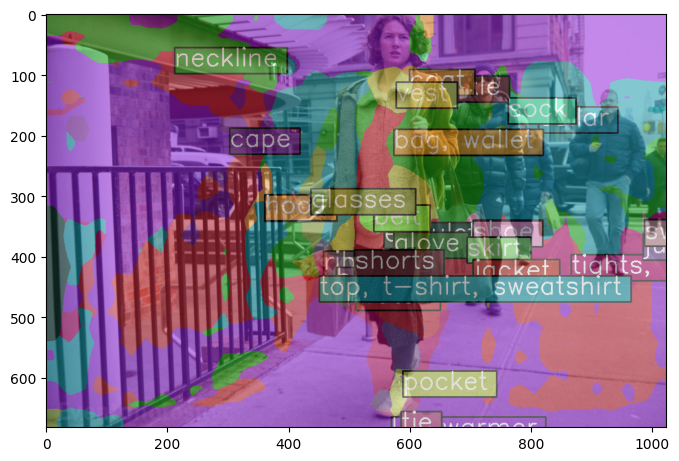

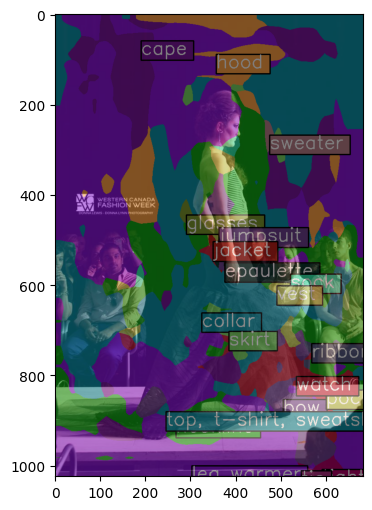

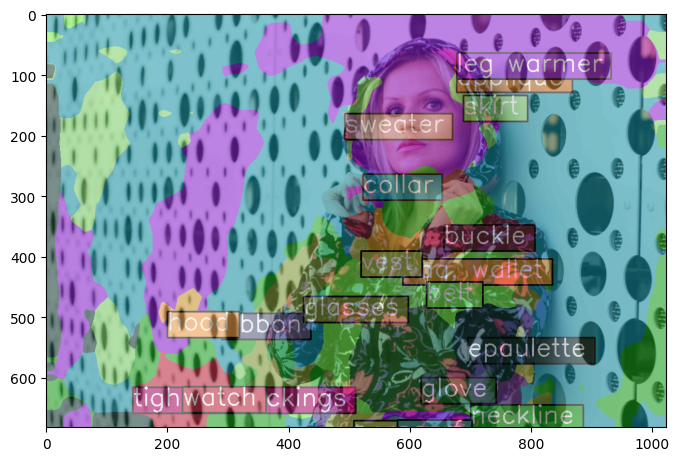

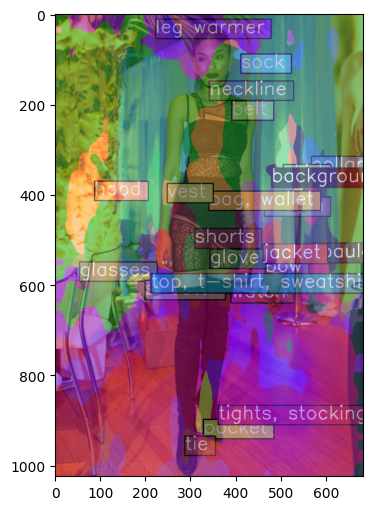

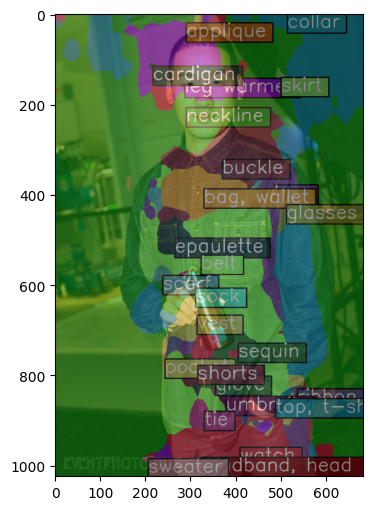

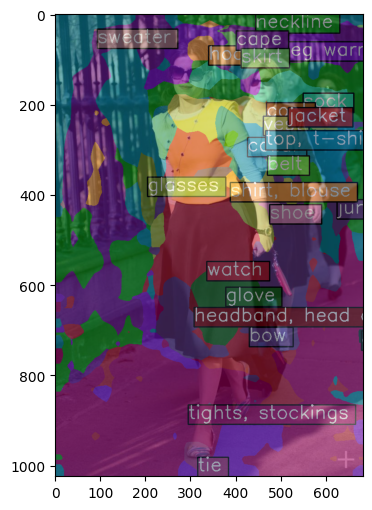

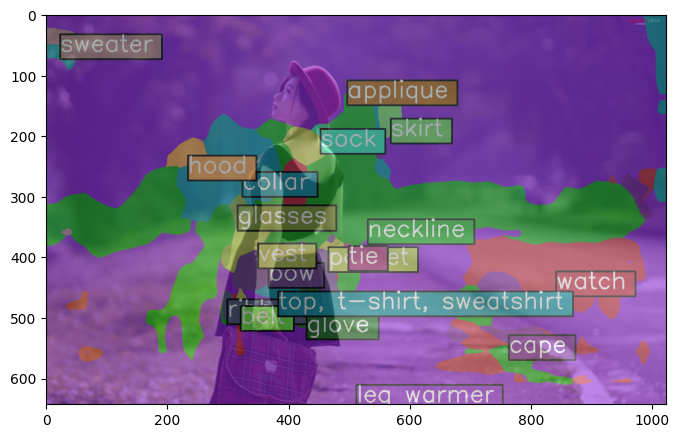

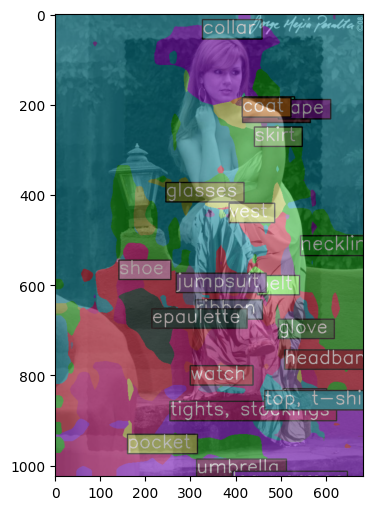

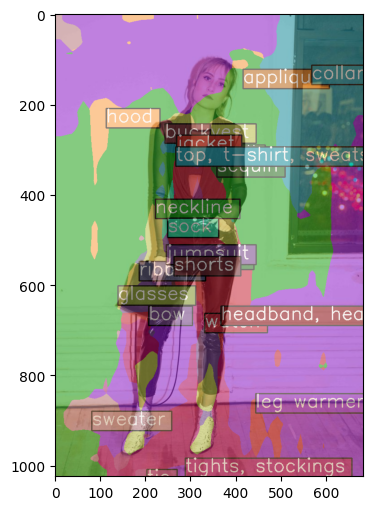

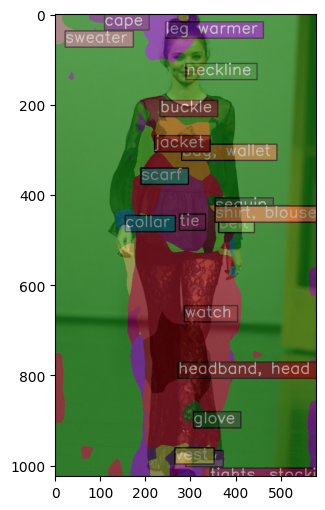

In [69]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_1000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

for i in range(10):
    ls_test = os.listdir('fashion/images/test2020')
    img = mmcv.imread(f'fashion/images/test2020/{ls_test[i]}')
    result = inference_model(model, img)
    plt.figure(figsize=(8, 6))
    vis_result = show_result_pyplot(model, img, result)
    plt.imshow(mmcv.bgr2rgb(vis_result))
    plt.show()
